### Практическая работа №2. Ускорение A/B тестов.

Азат Сибагатулин

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import os
import hashlib
from base64 import b64encode

from joblib import Parallel, delayed

### CUPED

$$ CUPED = metric - (covariate - E(covariate)) * theta $$

$$ theta = \frac{cov(metric, covariate)}{Var(covariate)} $$

covariate - метрика  до эксперимента
 
metric - метрика после эксперимента 

$$ metric_{cuped} = metric - \theta * covariate$$

$$ E(metric_{cuped}) = E(metric) $$

$$ Var(metric_{cuped})_{min} = Var(metric) + \theta^2*Var(metric) - 2\theta*cov(metric, covariate) = $$

$$ = Var(metric)(1 - corr(metric, covariance)) $$

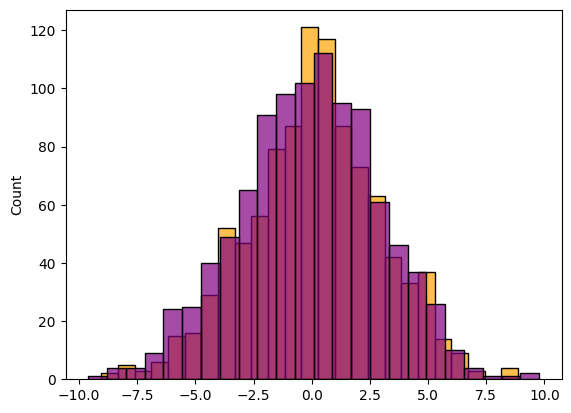

In [2]:
size = 1000
metric = np.random.normal(loc=0, scale=3, size=size)
covariate = np.random.normal(loc=0, scale=3, size=size)
# сортирую, чтобы была корреляция
metric.sort()
covariate.sort()

sns.histplot(metric, alpha=0.7, color="orange")
sns.histplot(covariate, alpha=0.7, color="purple");

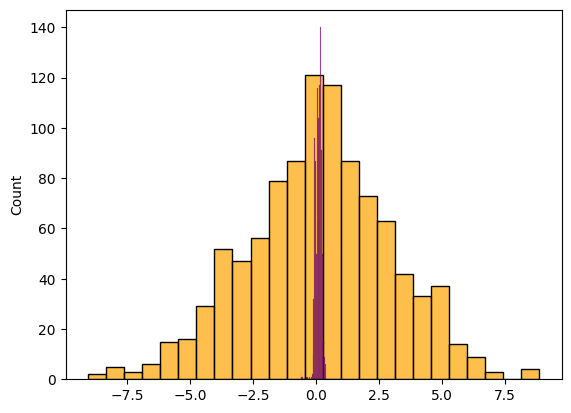

In [3]:
covariance = ( (metric - metric.mean()) * (covariate - covariate.mean()) ).sum() / size
 
theta = covariance / covariate.std() ** 2
cuped = metric - (covariate - covariate.mean()) * theta

sns.histplot(metric, alpha=0.7, color="orange")
sns.histplot(cuped, alpha=0.7, color="purple");

### Data

In [2]:
shop_metrics_new = pd.read_csv('data_shop/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')[["user_id", "group", "cart_added_cnt"]]
shop_metrics_old = pd.read_csv('data_shop/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')[["user_id", "group", "cart_added_cnt"]]
shop_users_info = pd.read_csv('data_shop/shop_df_users.csv').drop(columns='Unnamed: 0')

Метрики:
   - is_viewed - айтем товара просмотрен
   - products_viewed_cnt - количество уникальных просмотренных айтемов
   - price_sum - суммарная цена товаров
   - is_cart_added - товар добавлен в корзину
   - is_purchased - товар куплен
   - cart_added_cnt - количество товаров, добавленных в корзину
   - purchased_cnt - количество купленных товаров

In [3]:
shop_metrics_new.head(3)

,user_id,group,cart_added_cnt
0,1515915625353230683,A,0
1,1515915625353234047,A,0
2,1515915625353236157,A,0


In [4]:
shop_metrics_new.shape, shop_metrics_new.user_id.nunique()

((222521, 3), 222521)

In [5]:
shop_metrics_old.head(3)

,user_id,group,cart_added_cnt
0,1515915625353226922,B,0
1,1515915625353230067,A,0
2,1515915625353230683,A,0


In [6]:
shop_metrics_old.shape, shop_metrics_old.user_id.nunique()

((406863, 3), 406863)

In [7]:
shop_users_info.head(3)

,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m


### Метрика ```cart_added_cnt```

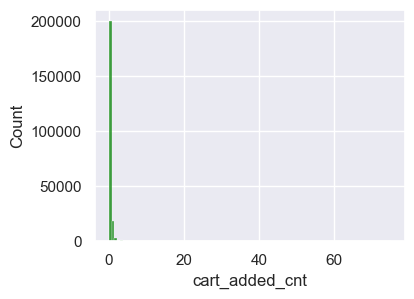

In [8]:
sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=shop_metrics_new, x='cart_added_cnt', bins=100, color='green');

In [9]:
shop_metrics_new.groupby('group')['cart_added_cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,111321.0,0.135042,0.616917,0.0,0.0,0.0,0.0,61.0
B,111200.0,0.138552,0.651705,0.0,0.0,0.0,0.0,75.0


In [10]:
# посчитаем параметры и вычислим "край" метрики для подхода "3 стандартных отклонения"

print(f" metric mean: {shop_metrics_new['cart_added_cnt'].mean()}, \
         metric std: {shop_metrics_new['cart_added_cnt'].std()}, \
         metric edge: {(shop_metrics_new['cart_added_cnt'].mean() + 3 * shop_metrics_new['cart_added_cnt'].std())}")

 metric mean: 0.13679607767356788,          metric std: 0.6345408834915941,          metric edge: 2.0404187281483503


In [11]:
np.percentile(shop_metrics_new['cart_added_cnt'], 99)

2.0

In [12]:
def salt_generator() -> str:
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def groups_splitter(df: pd.DataFrame, 
                    user_salt: str | None = None) -> pd.DataFrame:
    salt = user_salt if user_salt else salt_generator()
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))
    return df.drop("hash", axis="columns")

### 0. Мощность и корректность на сырой метрике ```cart_added_cnt```

In [13]:
def run_aa_test(df, effect, col="cart_added_cnt", criterion=stats.ttest_ind):
    new_df = groups_splitter(df[["user_id", col]])

    vec_a = new_df[new_df.group == "A"][col]
    vec_b = new_df[new_df.group == "B"][col]

    # Effect
    vec_b_effect = vec_b * effect

    p_correctness = criterion(vec_a, vec_b).pvalue
    p_power = criterion(vec_a, vec_b_effect).pvalue
    return p_correctness, p_power

 power: 6.6000000000000005% , correctness: 94.39999999999999%


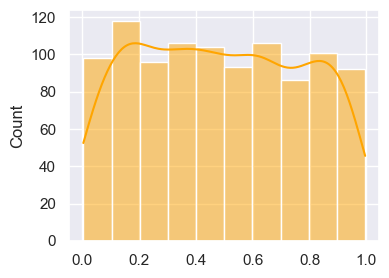

In [16]:
effect = 1.005
metric_column = "cart_added_cnt"
criterion = stats.ttest_ind

result = Parallel(n_jobs=-1)(
    delayed(run_aa_test)(shop_metrics_new, effect, metric_column, criterion) 
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='orange', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

Мощность сырой метрики 7%, корректность 94%

### 1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на метрике ```cart_added_cnt```

In [17]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis="index")
    df["rank"] = df[metric].rank()
    return df


def run_aa_test_for_rank(df, effect, col="cart_added_cnt", criterion=stats.ttest_ind):
    new_df = groups_splitter(df[["user_id", col]])

    # No effect
    ranked_df = rank_transformation(new_df[new_df.group == "A"],
                                    new_df[new_df.group == "B"], col)
    
    vec_a = ranked_df[ranked_df.group == "A"]["rank"]
    vec_b = ranked_df[ranked_df.group == "B"]["rank"]

    # Effect
    vec_b_effect = new_df[new_df.group == "B"][col] * effect
    new_df_b = new_df[new_df.group == "B"].drop(columns=[col])
    new_df_b[col] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(new_df[new_df.group == "A"], new_df_b, col)
    vec_a_power = ranked_df_effect[ranked_df_effect.group == "A"]["rank"]
    vec_b_power = ranked_df_effect[ranked_df_effect.group == "B"]["rank"]
    
    p_correctness = criterion(vec_a, vec_b).pvalue
    p_power = criterion(vec_a_power, vec_b_power).pvalue
    return p_correctness, p_power

In [18]:
effect = 1.005

**1. Ранговая трансофрмация ```cart_added_cnt``` -> ```rank```**

**2. t-test на метрике ```rank```**

 power: 100.0% , correctness: 93.7%


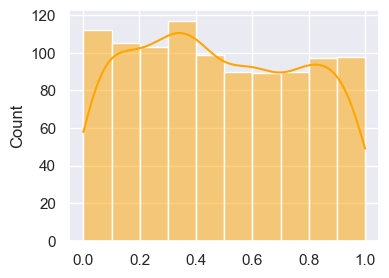

In [19]:
metric_column = "cart_added_cnt"
criterion = stats.ttest_ind

result = Parallel(n_jobs=-1)(
    delayed(run_aa_test_for_rank)(shop_metrics_new, effect, metric_column, criterion) 
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='orange', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

После применения ранговой трансформации мощность увеличилась до 100%❗

**1. Манна-Уитни на метрике ```cart_added_cnt```**

В теории я должен получить такой же результат, как и при ранговой трансформации https://booking.ai/increasing-sensitivity-of-experiments-with-the-rank-transformation-draft-c01aff70b255

 power: 100.0% , correctness: 94.8%


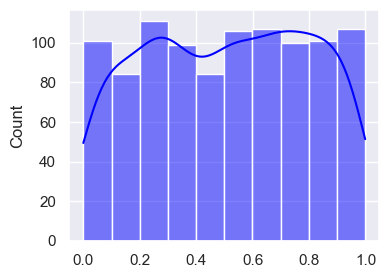

In [20]:
metric_column = "cart_added_cnt"
criterion = stats.mannwhitneyu

result = Parallel(n_jobs=-1)(
    delayed(run_aa_test)(shop_metrics_new, effect, metric_column, criterion) 
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

Получил тот же результат - мощность 100%

Ранговая трансформация увеличивает чувствительность метрики

In [21]:
ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == "A"],
                             shop_metrics_new[shop_metrics_new.group == "B"], 
                             "cart_added_cnt")

In [22]:
a_avg, a_std = ranked[ranked.group == "A"]["cart_added_cnt"].mean(), ranked[ranked.group == "A"]["cart_added_cnt"].std()
b_avg, b_std = ranked[ranked.group == "B"]["cart_added_cnt"].mean(), ranked[ranked.group == "B"]["cart_added_cnt"].std()
print(f"Mean rank A {a_avg:.3f} | Std: {a_std:.3f}")
print(f"Mean rank B {b_avg:.3f} | Std: {b_std:.3f}")
print(f"Difference in means {(b_avg - a_avg) / a_avg * 100:.5f} %")

stats.mannwhitneyu(ranked[ranked.group == "A"]["cart_added_cnt"], 
                   ranked[ranked.group == "B"]["cart_added_cnt"])

Mean rank A 0.135 | Std: 0.617
Mean rank B 0.139 | Std: 0.652
Difference in means 2.59938 %


MannwhitneyuResult(statistic=6179368188.5, pvalue=0.2025319893087626)

In [23]:
a_avg, a_std = ranked[ranked.group == "A"]["rank"].mean(), ranked[ranked.group == "A"]["rank"].std()
b_avg, b_std = ranked[ranked.group == "B"]["rank"].mean(), ranked[ranked.group == "B"]["rank"].std()
print(f"Mean rank A {a_avg:.3f} | Std: {a_std:.3f}")
print(f"Mean rank B {b_avg:.3f} | Std: {b_std:.3f}")
print(f"Difference in mean ranks {(b_avg - a_avg) / a_avg * 100:.5f} %")

stats.ttest_ind(ranked[ranked.group == "A"]["rank"], 
                ranked[ranked.group == "B"]["rank"])

Mean rank A 111170.456 | Std: 33408.214
Mean rank B 111351.642 | Std: 33659.127
Difference in mean ranks 0.16298 %


TtestResult(statistic=-1.2743727811526857, pvalue=0.20253266477504916, df=222519.0)

**Вывод**:
- Ранговая трансформация увеличивает чувствительность метрики
- Применение ранговой трансформации вместе с t-test такое же по воздействию на мощность, как применение Манна-Уитни 

### 2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике ```cart_added_cnt```
- логарфимированной метрике ```cart_added_cnt```
- метрике ```cart_added_cnt``` (а после подвергнуть ранговому преобразованию)

В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped

In [24]:
def cuped_transform(df, metrics):
    new_columns = [str(m + "_cuped") for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m + "_covariate")
        cuped_column = str(m + "_cuped")
        mean_covariate = df_mini[covariate_column].mean()

        theta = (
            df_mini[m].cov(df_mini[covariate_column])
        ) / df_mini[covariate_column].var()
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta
    
    df.update(df_mini)
    return df.drop_duplicates()


# 1. CUPED на обычной метрике
def run_aa_test_cuped(df, effect, col="cart_added_cnt", criterion=stats.ttest_ind):
    new_df = groups_splitter(df[["user_id", col]])
    all_df = pd.merge(new_df, shop_metrics_old[["user_id", col]], on=["user_id"], how="left")
    all_df.rename(inplace=True, columns={f"{col}_x": col, f"{col}_y": f"{col}_covariate"})

    # No effect
    cuped_df = cuped_transform(all_df, [col])
    
    vec_a = cuped_df[cuped_df.group == "A"][f"{col}_cuped"]
    vec_b = cuped_df[cuped_df.group == "B"][f"{col}_cuped"]
    
    # Effect
    all_df.loc[all_df.group == "B", col] *= effect
    
    cuped_df_effect = cuped_transform(all_df, [col])
    
    vec_a_power = cuped_df_effect[cuped_df_effect.group == "A"][f"{col}_cuped"]
    vec_b_power = cuped_df_effect[cuped_df_effect.group == "B"][f"{col}_cuped"]

    p_correctness = criterion(vec_a, vec_b).pvalue
    p_power = criterion(vec_a_power, vec_b_power).pvalue
    return p_correctness, p_power


# 2. CUPED на логарифмированной метрике
def run_aa_test_log(df, effect, col="cart_added_cnt", criterion=stats.ttest_ind):
    new_df = groups_splitter(df[["user_id", col]])
    all_df = pd.merge(new_df, shop_metrics_old[["user_id", col]], on=["user_id"], how="left")
    all_df.rename(inplace=True, columns={f"{col}_x": col, f"{col}_y": f"{col}_covariate"})

    # No effect
    all_df[f"{col}_ln"] = np.log(all_df[col] + 1)
    all_df[f"{col}_ln_covariate"] = np.log(all_df[f"{col}_covariate"] + 1)

    cuped_df = cuped_transform(all_df, [f"{col}_ln"])
    
    vec_a = cuped_df[cuped_df.group == "A"][f"{col}_ln_cuped"]
    vec_b = cuped_df[cuped_df.group == "B"][f"{col}_ln_cuped"]

    # Effect
    all_df.loc[all_df.group == "B", col] *= effect
    all_df[f"{col}_ln"] = np.log(all_df[col] + 1)
    # кажется, что ковариате эффект не нужен
    # all_df.loc[all_df.group == "B", f"{col}_covariate"] *= effect 
    # all_df[f"{col}_ln_covariate"] = np.log(all_df[f"{col}_covariate"] + 1)
    
    cuped_df_effect = cuped_transform(all_df, [f"{col}_ln"])

    vec_a_power = cuped_df_effect[cuped_df_effect.group == "A"][f"{col}_ln_cuped"]
    vec_b_power = cuped_df_effect[cuped_df_effect.group == "B"][f"{col}_ln_cuped"]

    p_correctness = criterion(vec_a, vec_b).pvalue
    p_power = criterion(vec_a_power, vec_b_power).pvalue
    return p_correctness, p_power


# 3. CUPED на обычной метрике + Ранговое преобразование
def run_aa_test_for_cuped_rank(df, effect, col="cart_added_cnt", criterion=stats.ttest_ind):
    new_df = groups_splitter(df[["user_id", col]])
    all_df = pd.merge(new_df, shop_metrics_old[["user_id", col]], on=["user_id"], how="left")
    all_df.rename(inplace=True, columns={f"{col}_x": col, f"{col}_y": f"{col}_covariate"})

    # No effect
    cuped_df = cuped_transform(all_df, [col])
    ranked_df = rank_transformation(cuped_df[cuped_df.group == "A"],
                                    cuped_df[cuped_df.group == "B"], 
                                    f"{col}_cuped")
    
    vec_a = ranked_df[ranked_df.group == "A"]["rank"]
    vec_b = ranked_df[ranked_df.group == "B"]["rank"]

    # Effect
    all_df.loc[all_df.group == "B", col] *= effect

    cuped_df_effect = cuped_transform(all_df, [col])
    ranked_df_effect = rank_transformation(cuped_df_effect[cuped_df_effect.group == "A"], 
                                    cuped_df_effect[cuped_df_effect.group == "B"], 
                                    f"{col}_cuped")
    
    vec_a_power = ranked_df_effect[ranked_df_effect.group == "A"]["rank"]
    vec_b_power = ranked_df_effect[ranked_df_effect.group == "B"]["rank"]
    
    p_correctness = criterion(vec_a, vec_b).pvalue
    p_power = criterion(vec_a_power, vec_b_power).pvalue
    return p_correctness, p_power

In [25]:
effect = 1.005
criterion = stats.ttest_ind

#### 1. **```cart_added_cnt```+ CUPED**

In [26]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[["user_id", "cart_added_cnt"]], on=["user_id"], how="left")
shop_metrics_all.rename(inplace=True, columns={"cart_added_cnt_x": "cart_added_cnt", "cart_added_cnt_y": "cart_added_cnt_covariate"})

# CUPED(cart_added_cnt)
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ["cart_added_cnt"])
shop_metrics_all_cuped[shop_metrics_all_cuped.cart_added_cnt_cuped < 0].head(3)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
23,1515915625354822642,B,1,2,293.84,0.0,0.0,0,0,1,-0.802231
30,1515915625355398801,B,1,28,1414.53,0.0,0.0,1,1,3,-1.672215
33,1515915625355805313,A,1,4,1336.40,0.0,0.0,1,0,6,-4.477190


- **Сравним средние в исходной метрике и CUPED метрике**:

In [27]:
print(f'mean(без cuped A): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        mean(без cuped B): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}')
print(f'mean(cuped A): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        mean(cuped B): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')

mean(без cuped A): 0.1350419058398685,         mean(без cuped B): 0.1385521582733813
mean(cuped A): 0.13638231572657297,         mean(cuped B): 0.13721028984714181


Средние не изменились

- **Сравним дисперсии в исходной метрике и CUPED метрике**:

In [28]:
print(f'var(без cuped A): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
        var(без cuped B): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}')
print(f'var(cuped A): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
        var(cuped B): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')

var(без cuped A): 0.3805867322090304,         var(без cuped B): 0.4247189893567569
var(cuped A): 0.01823518359964533,         var(cuped B): 0.021495363455396536


Дисперсия снизилась на порядок в обеих группах.

- **Мощность CUPED**

 power: 23.0% , correctness: 95.7%


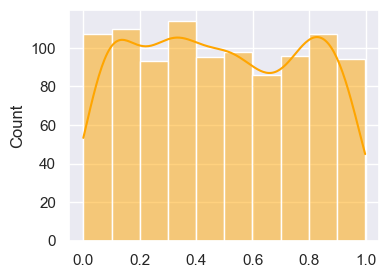

In [29]:
metric_column = "cart_added_cnt"

result = Parallel(n_jobs=-1)(
    delayed(run_aa_test_cuped)(shop_metrics_new, effect, metric_column, criterion) 
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='orange', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

Сравнение с сырой метрикой:
- мощность: ```7% => 23%```
- корректность: ```94% => 96%```

#### **2. ```log(cart_added_cnt)``` + CUPED**

In [30]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[["user_id", "cart_added_cnt"]], on=["user_id"], how="left")
shop_metrics_all.rename(inplace=True, columns={"cart_added_cnt_x": "cart_added_cnt", "cart_added_cnt_y": "cart_added_cnt_covariate"})

# np.log(cart_added_cnt)
shop_metrics_all["cart_added_cnt_ln"] = np.log(shop_metrics_all["cart_added_cnt"] + 1)
shop_metrics_all["cart_added_cnt_ln_covariate"] = np.log(shop_metrics_all["cart_added_cnt_covariate"] + 1)

# CUPED(cart_added_cnt_ln)
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ["cart_added_cnt_ln"])
shop_metrics_all_cuped[shop_metrics_all_cuped["cart_added_cnt_ln_cuped"] < 0].head(3)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_ln,cart_added_cnt_ln_covariate,cart_added_cnt_ln_cuped
23,1515915625354822642,B,1,2,293.84,0.0,0.0,0,0,1,0.000000,0.693147,-0.589897
30,1515915625355398801,B,1,28,1414.53,0.0,0.0,1,1,3,0.693147,1.386294,-0.566651
33,1515915625355805313,A,1,4,1336.40,0.0,0.0,1,0,6,0.693147,1.945910,-1.107499


- **Сравним средние в прологарифмированной метрике и CUPED прологарифмированной метрике**:

In [31]:
print(f'mean(без cuped A): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln"].mean()}, \
        mean(без cuped B): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln"].mean()}')
print(f'mean(cuped A): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln_cuped"].mean()}, \
        mean(cuped B): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln_cuped"].mean()}')

mean(без cuped A): 0.07974289062640032,         mean(без cuped B): 0.08132020317245879
mean(cuped A): 0.08034157852348374,         mean(cuped B): 0.08072086382541542


Средние **не изменились**

- **Сравним дисперсии в прологарифмированной метрике и CUPED прологарифмированной метрике**:

In [32]:
print(f'var(без cuped A): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln"].var()}, \
        var(без cuped B): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln"].var()}')
print(f'var(cuped A): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln_cuped"].var()}, \
        var(cuped B): {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln_cuped"].var()}')

var(без cuped A): 0.06466232955752058,         var(без cuped B): 0.06628259108478471
var(cuped A): 0.002055014378642917,         var(cuped B): 0.0017558187333519078


Дисперсия **снизилась на порядок** в обеих группах.

- **Мощность**:

 power: 30.7% , correctness: 94.69999999999999%


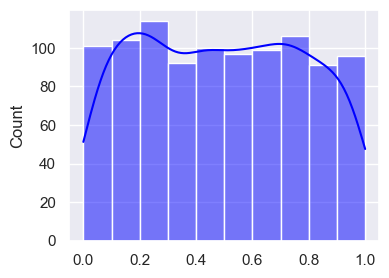

In [33]:
metric_column = "cart_added_cnt"

result = Parallel(n_jobs=-1)(
    delayed(run_aa_test_log)(shop_metrics_new, effect, metric_column, criterion) 
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

Сравнение с сырой метрикой:
- мощность: ```7% => 31%```
- корректность: ```94% => 95%```

#### **3. CUPED + ```rank(cart_added_cnt_cuped)```**

In [34]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[["user_id", "cart_added_cnt"]], on=["user_id"], how="left")
shop_metrics_all.rename(inplace=True, columns={"cart_added_cnt_x": "cart_added_cnt", "cart_added_cnt_y": "cart_added_cnt_covariate"})

# CUPED(cart_added_cnt)
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ["cart_added_cnt"])

# Rank(CUPED(cart_added_cnt))
shop_metrics_all_cuped_rank = rank_transformation(shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"],
                                                  shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"],
                                                  "cart_added_cnt_cuped")
shop_metrics_all_cuped_rank[shop_metrics_all_cuped_rank["cart_added_cnt_cuped"] < 0].head(3)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped,rank
33,1515915625355805313,A,1,4,1336.40,0.0,0.0,1,0,6,-4.477190,23.0
37,1515915625356207586,A,1,3,1141.29,0.0,0.0,0,0,1,-0.802231,371.0
39,1515915625356687705,A,1,2,48.58,0.0,0.0,0,0,1,-0.802231,371.0


- **Сравним средние**:

In [35]:
print(f'mean(без cuped A): {shop_metrics_all_cuped_rank[shop_metrics_all_cuped_rank.group == "A"]["cart_added_cnt"].mean()}, \
        mean(без cuped B): {shop_metrics_all_cuped_rank[shop_metrics_all_cuped_rank.group == "B"]["cart_added_cnt"].mean()}')
print(f'mean(cuped A): {shop_metrics_all_cuped_rank[shop_metrics_all_cuped_rank.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        mean(cuped B): {shop_metrics_all_cuped_rank[shop_metrics_all_cuped_rank.group == "B"]["cart_added_cnt_cuped"].mean()}')

mean(без cuped A): 0.1350419058398685,         mean(без cuped B): 0.1385521582733813
mean(cuped A): 0.13638231572657297,         mean(cuped B): 0.13721028984714181


Средние **не изменились** (равносильно первому случаю)

- **Сравним дисперсии**:

In [36]:
print(f'var(без cuped A): {shop_metrics_all_cuped_rank[shop_metrics_all_cuped_rank.group == "A"]["cart_added_cnt"].var()}, \
        var(без cuped B): {shop_metrics_all_cuped_rank[shop_metrics_all_cuped_rank.group == "B"]["cart_added_cnt"].var()}')
print(f'var(cuped A): {shop_metrics_all_cuped_rank[shop_metrics_all_cuped_rank.group == "A"]["cart_added_cnt_cuped"].var()}, \
        var(cuped B): {shop_metrics_all_cuped_rank[shop_metrics_all_cuped_rank.group == "B"]["cart_added_cnt_cuped"].var()}')

var(без cuped A): 0.3805867322090304,         var(без cuped B): 0.4247189893567569
var(cuped A): 0.01823518359964533,         var(cuped B): 0.021495363455396536


Дисперсия **снизилась на порядок** в обеих группах (равносильно первому случаю)

- **Мощность**:

 power: 100.0% , correctness: 95.6%


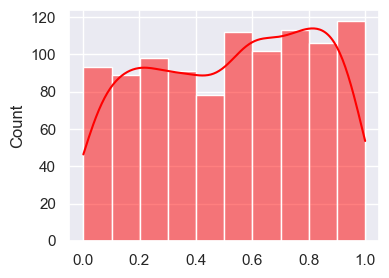

In [37]:
metric_column = "cart_added_cnt"

result = Parallel(n_jobs=-1)(
    delayed(run_aa_test_for_cuped_rank)(shop_metrics_new, effect, metric_column, criterion) 
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='red', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

Сравнение с сырой метрикой:
- мощность: ```7% => 100%```
- корректность: ```94% => 96%```

**Вывод**:
- можно увеличить мощность метрики за счёт преобразований (CUPED, ранговое преобразование, логарифмирование) и их комбинаций
- самое мощное преобразование - ранговое (выявляет изменение медианы, а не среднего => меняется контекст применения)

### 3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные)
- на метрике ```cart_added_cnt```

In [22]:
effect = 1.05
criterion = stats.ttest_ind

Во всех примерах буду применять численную бакетизацию:

1) отсортирую метрику
2) разобью на бакеты и возьму среднее

- **Логнормальное распределение**

Без бакетизации

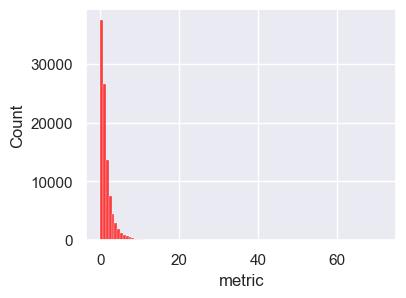

In [23]:
size = 100000
metric = np.random.lognormal(mean=0, sigma=1, size=size)
metric.sort()

df = pd.DataFrame({"user_id": range(size), "metric": metric})

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(df.metric, bins=100, color='red');

 power: 100.0% , correctness: 94.89999999999999%


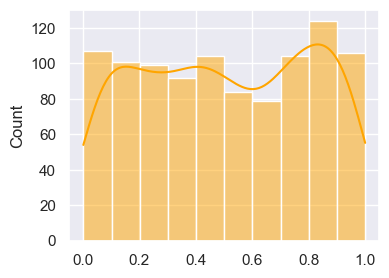

In [24]:
result = Parallel(n_jobs=-1)(
    delayed(run_aa_test)(df, effect, "metric", criterion)
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='orange', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

Бакетизация

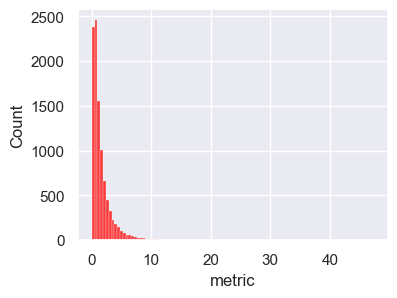

In [25]:
bucket = 10

metric_bucket = df.metric.to_numpy().reshape(size // bucket, -1).mean(axis=1)
# metric_bucket = np.percentile(df.metric.to_numpy().reshape(size // buckets, -1), 0.75, axis=1)
# metric_bucket = np.median(df.metric.to_numpy().reshape(size // buckets, -1), axis=1)

df_bucket = pd.DataFrame({"user_id": range(size // bucket), "metric": metric_bucket})

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(df_bucket.metric, bins=100, color='red');

 power: 46.6% , correctness: 94.89999999999999%


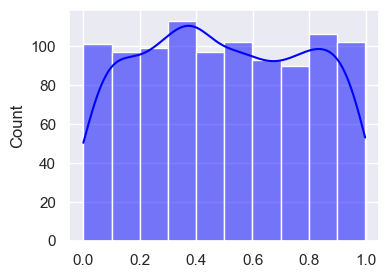

In [26]:
result = Parallel(n_jobs=-1)(
    delayed(run_aa_test)(df_bucket, effect, "metric", criterion)
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

- **Метрика ```cart_added_cnt```**:

Без бакетизации

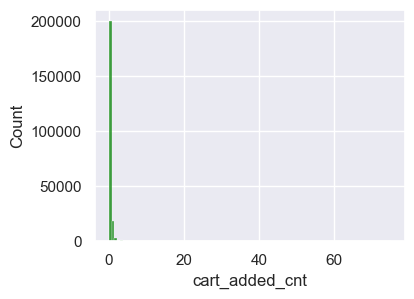

In [27]:
sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(shop_metrics_new.cart_added_cnt, bins=100, color='green');

 power: 71.39999999999999% , correctness: 95.6%


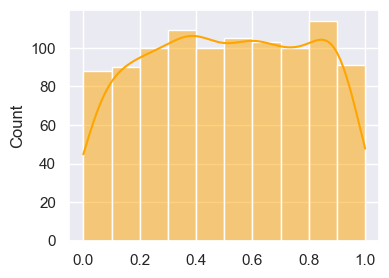

In [28]:
result = Parallel(n_jobs=-1)(
    delayed(run_aa_test)(shop_metrics_new, effect, "cart_added_cnt", criterion) 
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='orange', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

Бакетизация

In [29]:
shop_metrics_new.cart_added_cnt.shape[0] / 13

17117.0

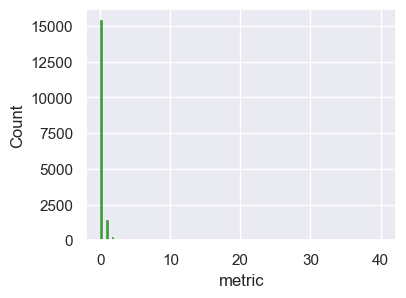

In [30]:
bucket = 13

metric_bucket = shop_metrics_new.cart_added_cnt.to_numpy()
metric_bucket.sort()

metric_bucket = metric_bucket.reshape(shop_metrics_new.shape[0] // bucket, -1).mean(axis=1)
# metric_bucket = np.percentile(df.metric.to_numpy().reshape(size // buckets, -1), 0.25, axis=1)
# metric_bucket = np.median(df.metric.to_numpy().reshape(size // buckets, -1), axis=1)

df_bucket = pd.DataFrame({"user_id": range(metric_bucket.shape[0]), "metric": metric_bucket})

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(df_bucket.metric, bins=100, color='green');

 power: 9.3% , correctness: 96.0%


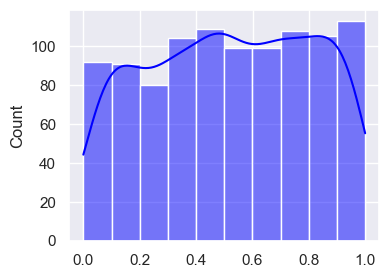

In [31]:
result = Parallel(n_jobs=-1)(
    delayed(run_aa_test)(df_bucket, effect, "metric", criterion) 
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

**Вывод**:

- Бакетизация снизила мощность

### 4. Реализовать постстратификацию на данных ```shop_metrics_old``` для метрики ```cart_added_cnt```:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+)
подсчитать результаты для случая без постстратификации и с постстратификацией
- проверить мощность и корректность t-критерия для постстратифицированного случая

$$ Y_{strat} = \sum_{k=1}^{K}{w_k * Y_k} $$

$ w_k $ - вес группы $k$

$ Y_k $ - метрика в группе $k$


In [14]:
effect = 1.05
criterion = stats.ttest_ind

**Без стратификации**:

 power: 88.9% , correctness: 95.1%


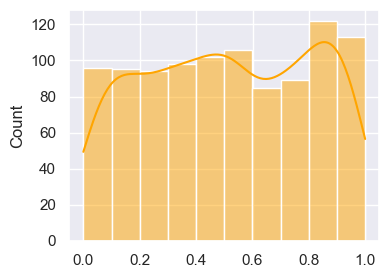

In [15]:
metric_column = "cart_added_cnt"

result = Parallel(n_jobs=-1)(
    delayed(run_aa_test)(shop_metrics_old, effect, metric_column, criterion) 
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='orange', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

**Стратификация**:

In [16]:
shop_users_info["age_group"] = (
    shop_users_info["user_age"]
    .mask(shop_users_info.user_age <= 24, "18_24")
    .mask((shop_users_info.user_age >= 25) & (shop_users_info.user_age <= 45), "25_45")
    .mask((shop_users_info.user_age >= 46) & (shop_users_info.user_age <= 60), "46_60")
    .mask((shop_users_info.user_age >= 61) & (shop_users_info.user_age <= 75), "61_75")
    .mask(shop_users_info.user_age >= 76, "more_76")
)

In [17]:
shop_old = pd.merge(shop_metrics_old[["user_id", "group", "cart_added_cnt"]], 
                    shop_users_info[["user_id", "age_group"]], on=["user_id"], how="left")
shop_old.head(3)

,user_id,group,cart_added_cnt,age_group
0,1515915625353226922,B,0,46_60
1,1515915625353230067,A,0,46_60
2,1515915625353230683,A,0,18_24


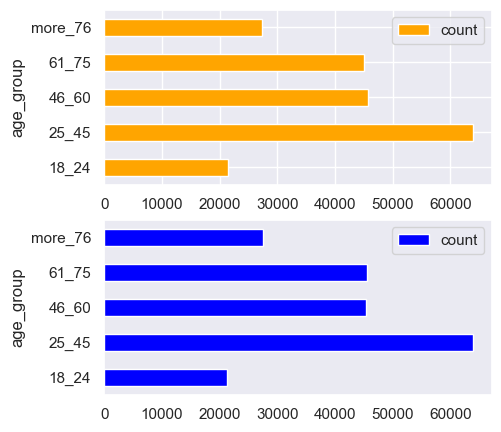

In [18]:
x = shop_old.groupby(["group", "age_group"])[["user_id"]].count().rename(columns={"user_id": "count"})

f, axs = plt.subplots(nrows=2, figsize=(5,5))
x.loc["A"].plot.barh(color="orange", ax=axs[0])
x.loc["B"].plot.barh(color="blue", ax=axs[1])
plt.grid(visible=False)
plt.legend();

In [19]:
N = shop_old.user_id.nunique()

strats_weights = {}

age_group_counts = shop_old.age_group.value_counts()

for age_group in age_group_counts.index:
    strats_weights[age_group] = age_group_counts[age_group] / N
strats_weights

{'25_45': 0.3143588873896127,
 '46_60': 0.2237878597955577,
 '61_75': 0.2222738366477168,
 'more_76': 0.1347333131791291,
 '18_24': 0.10484610298798366}

In [20]:
shop_old["cart_added_cnt_strat"] = shop_old["cart_added_cnt"].astype(float)

for age_group, w in strats_weights.items():
    shop_old.loc[shop_old["age_group"] == age_group, "cart_added_cnt_strat"] *= w

shop_old[shop_old.cart_added_cnt > 0].head(3)

,user_id,group,cart_added_cnt,age_group,cart_added_cnt_strat
9,1515915625353286099,B,2,61_75,0.444548
17,1515915625353457259,A,1,61_75,0.222274
29,1515915625353534622,B,1,18_24,0.104846


 power: 85.1% , correctness: 96.0%


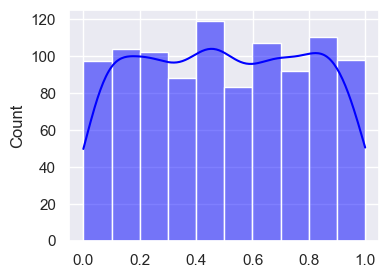

In [21]:
metric_column = "cart_added_cnt_strat"

result = Parallel(n_jobs=-1)(
    delayed(run_aa_test)(shop_old, effect, metric_column, criterion) 
    for _ in range(1000)
)

correctness = np.array([p[0] for p in result])
power = np.array([p[1] for p in result])

sns.set(rc={'figure.figsize':(4,3)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

print(f" power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% ,"
      f" correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%")

**Вывод**:
 
- Корректность  ```95% => 96%```

- Мощность немного снизилась ```89% => 85%```